# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2 : Propiedades en Venta</center>
## <center>Parte 2</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Redes Neuronales

In [1]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import shapely.speedups
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import re
from itertools import combinations
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.metrics import(f1_score,  recall_score, precision_score, accuracy_score, confusion_matrix)
import joblib
np.random.seed(1)
tf.random.set_seed(1)

## Redes Clasificacion

Para clasificar los datos del dataset tomamos el mismo criterio definir que viviendas son consideradas de precio alto, medio o bajo. 

In [2]:
viviendas_train=pd.read_csv('./TP1/Datasets/viviendas_caba_con_tipo_precio_train.csv').copy()
viviendas_test=pd.read_csv('./TP1/Datasets/viviendas_caba_con_tipo_precio_test.csv').copy()
viviendas = pd.concat([viviendas_train, viviendas_test])

In [3]:
viviendas.head(5)

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry,pxm2,tipo_precio
0,2021-12-15,2021-12-25,-34.555049,-58.490513,Saavedra,Departamento,2.0,1.0,58.0,49.0,167113.0,Departamento - Saavedra,POINT (-58.4905135 -34.5550487),2881.258621,Alto
1,2021-05-20,2021-06-05,-34.546991,-58.478553,Saavedra,Departamento,2.0,1.0,48.0,44.0,129000.0,Departamento - Saavedra,POINT (-58.4785532 -34.546991),2687.500000,Medio
2,2021-03-20,2021-04-16,-34.570842,-58.491805,Villa Urquiza,Departamento,2.0,1.0,62.0,58.0,124600.0,Venta Depto 2 amb Anticipo + Cuotas CAC V. Urq...,POINT (-58.4918048 -34.5708421),2009.677419,Medio
3,2021-07-17,2021-10-16,-34.589251,-58.402106,Recoleta,Departamento,3.0,2.0,60.0,60.0,196000.0,Excelente 3 ambientes en venta en Barrio Recoleta,POINT (-58.4021058 -34.5892511),3266.666667,Alto
4,2021-07-02,2022-02-09,-34.626290,-58.437632,Caballito,Departamento,3.0,2.0,67.0,61.0,235000.0,VENTA DEPARTAMENTO 3 AMB. EN CABALLITO,POINT (-58.4376325 -34.6262899),3507.462687,Alto


Hacemos un onehot encoding para poder utilizar columnas no numericas a la hora de entrenar los modelos

In [4]:
viviendas = pd.get_dummies(viviendas, columns = ["property_type"]) 
viviendas = pd.get_dummies(viviendas, columns = ["barrio"])
viviendas = pd.get_dummies(viviendas, columns = ["tipo_precio"])

In [5]:
viviendas_train, viviendas_test = train_test_split(viviendas, test_size=0.2, random_state=2)

Definimos las columnas que queremos predecir y las que usaremos para predecir

In [6]:
variables_a_predecir = ['tipo_precio_Alto', 'tipo_precio_Bajo', 'tipo_precio_Medio']

In [7]:
columnas_predictoras=viviendas_train.columns.to_list()
variables_a_remover = ['property_price', 'start_date', 'end_date', 'property_title', 'geometry', 'pxm2']
variables_a_remover.extend(variables_a_predecir)
for variable in variables_a_remover:
    columnas_predictoras.remove(variable)

Definimos una clase ModeloRedes, con la que vamos a crear las redes. Esto nos permite variar fácilmente  los distintos hiperparámetros

In [8]:
class ModeloRedes:
    def __init__(self, dataset_train, dataset_test, variables_predictoras, cantidad_de_primera_capa, funcion_activacion, optimizador, learning_rate, metrica, epoch, batch_size, modelo=None):
        self.variables_predictoras = variables_predictoras
        self.cantidad_primera_capa = cantidad_de_primera_capa
        self.funcion_activacion = funcion_activacion
        self.optimizador = optimizador
        self.learning_rate = learning_rate
        self.resultado = None
        self.metrica = metrica
        self.epoch = epoch
        self.batch_size = batch_size
        self.modelo = modelo

        
        self.x_test = dataset_test.loc[:,variables_predictoras]
        self.y_test = dataset_test.loc[:,variables_a_predecir]
        self.x_train = dataset_train.loc[:,variables_predictoras]
        self.y_train = dataset_train.loc[:,variables_a_predecir]
        self.x_test_original = None
        self.x_train_original = None
        self.escalar_datasets()
        if modelo == None:
            self.entrenar_modelo()
    
    def escalar_datasets(self):
        sscaler=StandardScaler()
        sscaler.fit(pd.DataFrame(self.x_train))
        
        self.x_train_original = self.x_train
        self.x_test_original = self.x_test
        self.x_train=sscaler.transform(pd.DataFrame(self.x_train))
        self.x_test=sscaler.transform(pd.DataFrame(self.x_test))

    def entrenar_modelo(self):
    # Creo un modelo Red Neuronal
        d_in= len(self.variables_predictoras)
        d_out=3

        capas = [
            # input layer
            keras.layers.Dense(d_in,input_shape=(d_in,), activation= self.funcion_activacion)
        ]

        #inserta capas que van decreciendo en cantidad de neuronas
        for i in range(self.cantidad_primera_capa,4,-1):
            capas.append(keras.layers.Dense(i, activation= self.funcion_activacion ))

        capas.append(keras.layers.Dense(d_out, activation= 'softmax'))
        self.modelo = keras.Sequential(capas)

        self.modelo.compile(
        optimizer= self.optimizador(self.learning_rate), 
        loss='categorical_crossentropy', 
        metrics=[self.metrica], 
        )

        self.modelo.fit(self.x_train,self.y_train,epochs=self.epoch,batch_size=self.batch_size,verbose=False)

    
    #toma las salidas que indican la probabilidad de que cierta vivienda sea de un tipo determinado, y a la mas grande la reemplaza por 1 y a las mas chicas por 0
    def transformar_predicciones(self, y_pred):
        for i in y_pred:
            pos_maximo = 0
            for j in range(len(i)):
                if i[j] > i[pos_maximo]:
                    pos_maximo = j
            for j in range(len(i)):
                if j == pos_maximo:
                    i[j] = 1
                else:
                    i[j]= 0
        return y_pred

    def testear_modelo(self):
        y_pred=self.modelo.predict(self.x_test)

        y_pred = self.transformar_predicciones(y_pred)

        self.resultado = f1_score(self.y_test.values.tolist(),y_pred, average='weighted')

        return self.resultado
    
    def matriz_confusion(self):
        y_pred=self.modelo.predict(self.x_test)
        y_pred = self.transformar_predicciones(y_pred)
        matriz = confusion_matrix(self.y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
        labels = {"alto": 0, "bajo": 1,"medio": 2}
     
        plt.figure(figsize = (16, 9))
        sns.heatmap(matriz, annot = True,cmap = 'coolwarm', fmt="g", xticklabels=labels, yticklabels=labels)
        
        plt.title("Matriz de confusión")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()
        
    
    
    def info(self):
        print('\n\n Variables predictoras utilizadas: ',self.variables_predictoras , 
        '\n Cantidad de nueronas de la primera capa: ',self.cantidad_primera_capa ,
        '\n Funcion de activacion: ',self.funcion_activacion ,
        '\n Optimizador: ',self.optimizador ,
        '\n Learning Rate: ',self.learning_rate 
        ,'\n Metrica: ',self.metrica ,
        '\n Epoch: ',self.epoch ,
        '\n Batch size',self.batch_size
        )

        y_pred=self.modelo.predict(self.x_test)
        y_pred = self.transformar_predicciones(y_pred)

        accuracy = accuracy_score(self.y_test.values.tolist(), y_pred)
        recall = recall_score(self.y_test.values.tolist(), y_pred, average="weighted")
        presicion = precision_score(self.y_test.values.tolist(), y_pred, average="weighted")
        f1 = f1_score(self.y_test.values.tolist(),y_pred, average='weighted')

        print()
        print("accuracy:",accuracy)
        print("recall", recall)
        print("presicion", presicion)
        print('f1',f1)
        print()


### Randomizador

Utilizamos un random_validator para realizar la búsqueda de hiperparámetros. Como el dataset es muy grande primero buscamos los hiperparámetros sobre porciones del mismo, 3000 datos. Una vez encontremos algunos conjuntos de hiperparámetros que den buenas métricas, pasaremos a utilizar esos hiperparámetros para entrenar un modelo con todos los datos. Para reducir un poco la complejidad tomamos que siempre las neuronas siempre se colocan de manera piramidal, es decir que si la primera layer tiene 18 neuronas, la siguiente tendrá 17, luego 16 y así hasta llegar a 4

Lo que variamos es la función de activación, el optimizador, la learning rate, la metrica con la que optimiza, cantidad de neuronas, epoch y batch size. También variamos que columnas se utilizan para predecir.

In [9]:
def random_validator(cantidad_modelos, posibles_funcion_activacion, posibles_optimizador, 
    posibles_learning_rate, posibles_metricas, obtener_posibles_variables_predictoras):
    
    resultados = []
    for i in range(cantidad_modelos):

        variables_predictoras = obtener_posibles_variables_predictoras()
        cantidad_de_primera_capa = random.randrange(4, 20, 1)
        funcion_activacion = random.choice(posibles_funcion_activacion)
        optimizador = random.choice(posibles_optimizador)
        learning_rate = random.choice(posibles_learning_rate)
        metrica = random.choice(posibles_metricas)
        epoch = random.randrange(100, 300, 10)
        batch_size = random.randrange(10, 1000, 1)
        df_reducido = viviendas_train[:3000]
        df_train, df_test = train_test_split(df_reducido.loc[:],test_size=0.2)

        modelo = ModeloRedes(df_train, df_test, variables_predictoras, cantidad_de_primera_capa, funcion_activacion, optimizador, learning_rate, metrica, epoch, batch_size)
        resultados.append([modelo, modelo.testear_modelo()])
        modelo.info()
    return resultados

Definimos a continuación los posibles valores que pueden tomar los distintos parámetros a la hora de hacer un modelo random. Las columnas en particular las dividimos en dos categorías, aquellas importantes que representan una importante variabilidad de los datos, y aquellas que serian mas bien columnas extras. De esta manera siempre nos aseguramos que hayan al menos 1 columna importante ya que de lo contrario el resultado siempre resulta malo

In [10]:
columnas_importantes =  ['latitud', 'longitud', 'property_surface_total', 'property_surface_covered']
columnas_extras = []
for e in columnas_predictoras:
    if e not in columnas_importantes:
        columnas_extras.append(e)       

def agregar_columnas(posibles_variables_predictoras, columnas, cant_columnas):
            i = 0
            while (i < cant_columnas): 
                pos = random.randrange(i,len(columnas), 1)
                posibles_variables_predictoras.append(columnas[pos])
                columnas[i], columnas[pos] = columnas[pos], columnas[i]
                i += 1

                                        #vimos que los modelos buenos utilizaban "relu" asique dejamos de utilizar el resto dentro de random search
posibles_funcion_activacion = ['softmax',"relu","tanh", "sigmoid"]
posibles_metricas = ['AUC', 'accuracy', 'Precision', 'Recall']

posibles_learning_rate = [0.1, 0.01, 0.001]

In [11]:
def funcion_optimizadoraNADAM(learnigRate):
            return keras.optimizers.Nadam(learning_rate = learnigRate)

def funcion_optimizadoraRMSPROP(learnigRate):
            return keras.optimizers.RMSprop(learning_rate = learnigRate)

def funcion_optimizadoraADAMAX(learnigRate):
            return keras.optimizers.Adamax(learning_rate = learnigRate)

def funcion_optimizadoraADADELTA(learnigRate):
            return keras.optimizers.Adadelta(learning_rate = learnigRate)

def funcion_optimizadoraSGD(learnigRate):
            return keras.optimizers.SGD(learning_rate = learnigRate)

posibles_optimizador = [funcion_optimizadoraNADAM, funcion_optimizadoraRMSPROP, funcion_optimizadoraADAMAX, funcion_optimizadoraADADELTA, funcion_optimizadoraSGD]

In [12]:
def obtener_posibles_variables_predictoras():
        posibles_variables_predictoras = []     
        cant_columnas_importantes = random.randrange(1,len(columnas_importantes)+1, 1)
        cant_columnas_extras = random.randrange(0,len(columnas_extras)+1, 1)

        agregar_columnas(posibles_variables_predictoras, columnas_importantes, cant_columnas_importantes)
        agregar_columnas(posibles_variables_predictoras, columnas_extras, cant_columnas_extras)
        return posibles_variables_predictoras

### Entrenamiento de redes

#### Obtener hiperparámetros

In [13]:
#Hace 50 modelos con hiperparametros random sobre datasets de 3000 elementos
def obtener_50_modelos():
    resultados = random_validator(50, posibles_funcion_activacion, posibles_optimizador, posibles_learning_rate, posibles_metricas,obtener_posibles_variables_predictoras)

    return resultados

In [14]:
#dado un conjunto de modelos se queda con los modelos cuyo f1-score sea mayor a 0.55
def obtener_mejores(resultados):
    mejores = []
    for i in resultados:
        if (i[1] > 0.55 ):
            mejores.append(i)

    return mejores

In [15]:
mejores = []

Entrenamos 250 modelos random para obtener los hiperparámetros

In [16]:
"""for i in range(5):
    resultados = obtener_50_modelos()
    mejores.append(obtener_mejores(resultados))"""

'for i in range(5):\n    resultados = obtener_50_modelos()\n    mejores.append(obtener_mejores(resultados))'

Como esto toma mucho tiempo solo mostramos el entrenamiento de 10 modelos. Puede pasar que ninguno de los 10 modelos supere el límite de 0.55 en cuyo caso no habría obtenido ningún conjunto de hiperparámetros y habría que correr mas hasta que aleatoriamente se obtenga un buen conjunto de hiperparámetros.

In [17]:
def obtener_10_modelos():
    resultados = random_validator(10, posibles_funcion_activacion, posibles_optimizador, posibles_learning_rate, posibles_metricas,obtener_posibles_variables_predictoras)

    return resultados

In [18]:
resultados = obtener_10_modelos()
mejores.append(obtener_mejores(resultados))

19/19 [==============================] - 0s 654us/step


 Variables predictoras utilizadas:  ['property_surface_total', 'latitud', 'longitud'] 
 Cantidad de nueronas de la primera capa:  15 
 Funcion de activacion:  relu 
 Optimizador:  <function funcion_optimizadoraRMSPROP at 0x0000029B6A5295E0> 
 Learning Rate:  0.1 
 Metrica:  Recall 
 Epoch:  110 
 Batch size 158
19/19 [==============================] - 0s 942us/step

accuracy: 0.49666666666666665
recall 0.49666666666666665
presicion 0.24667777777777777
f1 0.3296362286562732

19/19 [==============================] - 0s 610us/step


 Variables predictoras utilizadas:  ['latitud', 'property_surface_total', 'barrio_Monte Castro', 'barrio_Villa Devoto', 'barrio_Villa Lugano', 'barrio_Catalinas', 'barrio_Floresta', 'barrio_Palermo', 'barrio_San Cristobal', 'barrio_Saavedra', 'barrio_Parque Avellaneda', 'barrio_San Telmo', 'barrio_Puerto Madero', 'barrio_Nuñez', 'barrio_Caballito', 'barrio_Parque Chacabuco', 'barrio_Villa Urquiza', 'barr

In [19]:
mejores

[[[<__main__.ModeloRedes at 0x29b7c02c310>, 0.5590885994483604]]]

#### Entrenamiento sobre todo el dataset

Una vez obtenemos un conjunto de modelos buenos, tomamos sus hiperparámetros y los entrenamos sobre el dataset de viviendas_train y testeamos sobre el viviendas_test. Los entrenamos 3 veces ya que dependiendo de la semilla inicial los resultados pueden variar, y de esta manera obtenemos mejores modelos. Esto lleva mucho tiempo por lo que también lo comentamos.

In [20]:
def reentrenar_tot(modelo):
    #modelo.info()
    mejor_modelo = ModeloRedes(
        viviendas_train, 
        viviendas_test, 
        modelo.variables_predictoras, 
        modelo.cantidad_primera_capa, 
        modelo.funcion_activacion, 
        modelo.optimizador, 
        modelo.learning_rate, 
        modelo.metrica, 
        modelo.epoch, 
        modelo.batch_size)
        
    mejor_modelo.testear_modelo()
    mejor_resultado = mejor_modelo.resultado 
   

    for i in range(2):
        print('valor a vencer', mejor_resultado)
        modelo_aux = ModeloRedes(
            viviendas_train, 
            viviendas_test, 
            modelo.variables_predictoras, 
            modelo.cantidad_primera_capa, 
            modelo.funcion_activacion, 
            modelo.optimizador, 
            modelo.learning_rate, 
            modelo.metrica, 
            modelo.epoch, 
            modelo.batch_size)

        resultado_aux = modelo_aux.testear_modelo()
        print('reentrenando intento', i+1)
        resultado_aux = modelo_aux.testear_modelo()
        print(resultado_aux)
        mejor_modelo.info()
        
        if resultado_aux < mejor_resultado:
            mejor_resultado = resultado_aux
            mejor_modelo = modelo_aux 
    return [mejor_modelo, mejor_resultado]

In [21]:
tots = []

In [22]:
"""
for i in mejores:
    for j in i:
        tots.append(reentrenar_tot(j[0]))
        print(tots[-1])
"""

'\nfor i in mejores:\n    for j in i:\n        tots.append(reentrenar_tot(j[0]))\n        print(tots[-1])\n'

Nos quedamos con el mejor modelo de los entrenados sobre todo el dataset

In [23]:
"""
mejor_modelo = tots[0]
for i in tots:
    if (i != None):
        if (i[1] > mejor_modelo[1]):
            mejor_modelo = i
            """

'\nmejor_modelo = tots[0]\nfor i in tots:\n    if (i != None):\n        if (i[1] > mejor_modelo[1]):\n            mejor_modelo = i\n            '

In [24]:
#mejor_modelo

Tuvimos algunos problemas al guardar nuestro objeto Modelo_redes, por lo que nos guardamos por una parte el modelo de Keras y por otra los hiperparámetros

In [25]:
"""
modelo = mejor_modelo[0]
dic = {'variables_predictoras': modelo.variables_predictoras, 'cantidad_primera_capa': modelo.cantidad_primera_capa,
'funcion_activacion': modelo.funcion_activacion, 'optimizador': modelo.optimizador,
'learning_rate': modelo.learning_rate, 'metrica': modelo.metrica,
'epoch': modelo.epoch, 'batch_size': modelo.batch_size,}
"""

"\nmodelo = mejor_modelo[0]\ndic = {'variables_predictoras': modelo.variables_predictoras, 'cantidad_primera_capa': modelo.cantidad_primera_capa,\n'funcion_activacion': modelo.funcion_activacion, 'optimizador': modelo.optimizador,\n'learning_rate': modelo.learning_rate, 'metrica': modelo.metrica,\n'epoch': modelo.epoch, 'batch_size': modelo.batch_size,}\n"

In [26]:
"""joblib.dump(dic, './Models/hyper_clasif_ultima_tanda') 
modelo.modelo.save('./Models/modelo_clasif_ultima_tanda')"""

"joblib.dump(dic, './Models/hyper_clasif_ultima_tanda') \nmodelo.modelo.save('./Models/modelo_clasif_ultima_tanda')"

EL mejor modelo obtenido tras realizar lo comentado anteriormente fue:

In [27]:
hyper = joblib.load('./Models/hiper_mejor_modelo_clasificacion')
new_model = keras.models.load_model('./Models/mejor_modelo_clasificacion')



modelo_redes = ModeloRedes(viviendas_train, viviendas_test, hyper['variables_predictoras'], hyper['cantidad_primera_capa'], hyper['funcion_activacion'],
 hyper['optimizador'], hyper['learning_rate'], hyper['metrica'],  hyper['epoch'], hyper['batch_size'], new_model)



 Variables predictoras utilizadas:  ['property_surface_total', 'longitud', 'latitud', 'property_surface_covered', 'barrio_Catalinas', 'barrio_Villa del Parque', 'barrio_Parque Chas', 'barrio_Chacarita', 'barrio_Paternal', 'barrio_Agronomía', 'barrio_Pompeya', 'barrio_Villa Riachuelo', 'barrio_Boca', 'barrio_Liniers', 'barrio_Villa Crespo', 'barrio_Puerto Madero', 'barrio_Villa Urquiza', 'barrio_Parque Patricios', 'barrio_Floresta', 'property_type_PH', 'barrio_Abasto', 'barrio_Congreso', 'barrio_Congreso', 'barrio_Velez Sarsfield', 'property_type_Departamento', 'barrio_Flores', 'property_rooms', 'barrio_Constitución', 'barrio_Saavedra', 'barrio_San Nicolás', 'barrio_Almagro', 'barrio_Boedo', 'barrio_Monte Castro', 'barrio_Monserrat', 'barrio_Barrio Norte', 'barrio_Las Cañitas', 'barrio_Caballito', 'barrio_Nuñez', 'barrio_Villa General Mitre', 'barrio_Villa Lugano', 'barrio_Centro / Microcentro', 'barrio_San Cristobal', 'barrio_Versalles', 'barrio_Villa Soldati', 'barrio_Colegiales', '

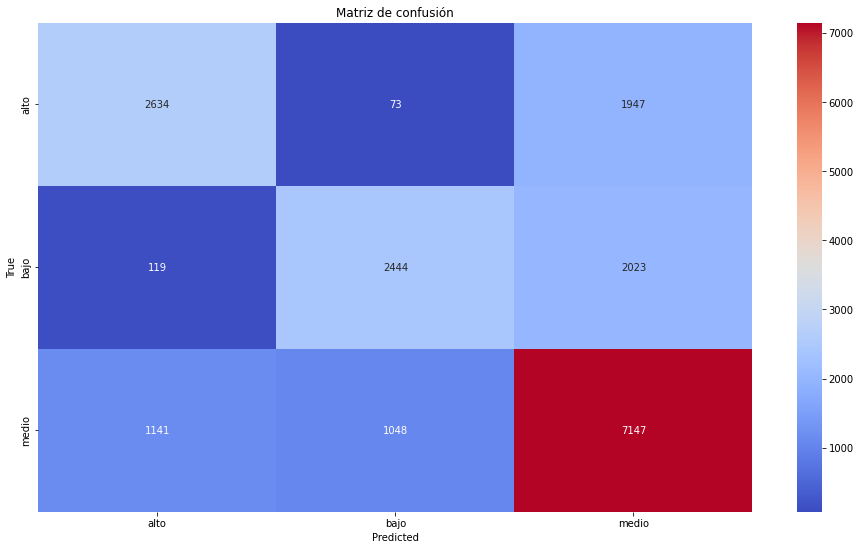

In [28]:
modelo_redes.info()
modelo_redes.matriz_confusion()

## Redes Regresión

In [29]:
viviendas_train=pd.read_csv('./TP1/Datasets/viviendas_caba_train.csv').copy()
viviendas_test=pd.read_csv('./TP1/Datasets/viviendas_caba_test.csv').copy()
viviendas = pd.concat([viviendas_train, viviendas_test])

Hacemos un OneHot encoding para poder utilizar columnas no numéricas a la hora de entrenar los modelos

In [30]:
viviendas = pd.get_dummies(viviendas, columns = ["property_type"])
viviendas = pd.get_dummies(viviendas, columns = ["barrio"])

Volvemos a separar en train y test

In [31]:
viviendas_train, viviendas_test = train_test_split(viviendas, test_size=0.2, random_state=2)

definimos las columnas que utilizaremos para entrenar las redes

In [32]:
columnas_predictoras=viviendas_train.columns.to_list()
for variable in ['property_price', 'start_date', 'end_date', 'property_title', 'geometry']:
    columnas_predictoras.remove(variable)

#### RANDOMIZADOR


Para entrenar las redes neuronales utilizaremos un random_search para optimizar los hiperparámetros, y luego utilizarlos para entrenar un modelo sobre todo el dataset. Probamos tanto normalizando el precio, usando mas funciones de activación, como sin normalizar el precio usando solo relu. El mejor resultado que obtuvimos resulto ser sin normalizar el precio, por lo que esta comentado el código que lo hace a continuación

In [33]:
#al instanciar un ModeloRedes crea y entrena una red neuronal con los hiperparametros pasados
class ModeloRedes:
    def __init__(self, dataset_train, dataset_test, variables_predictoras, cantidad_de_primera_capa, funcion_activacion, optimizador, learning_rate, metrica, epoch, batch_size, modelo=None):
        self.variables_predictoras = variables_predictoras
        self.cantidad_primera_capa = cantidad_de_primera_capa
        self.funcion_activacion = funcion_activacion
        self.optimizador = optimizador
        self.learning_rate = learning_rate
        self.resultado = None
        self.metrica = metrica
        self.epoch = epoch
        self.batch_size = batch_size
        self.modelo = modelo

        
        self.x_test = dataset_test.loc[:,variables_predictoras]
        self.y_test = dataset_test.loc[:,'property_price']
        self.x_train = dataset_train.loc[:,variables_predictoras]
        self.y_train = dataset_train.loc[:,'property_price']
        self.x_test_original = None
        self.x_train_original = None
        self.precio_maximo = max(max(dataset_test['property_price']), max(dataset_train['property_price']))
        self.escalar_datasets()
        if modelo == None:
            self.entrenar_modelo()
    
    def escalar_datasets(self):
        sscaler=StandardScaler()
        sscaler.fit(pd.DataFrame(self.x_train))
        self.x_train_original = self.x_train
        self.x_test_original = self.x_test
        self.x_train=sscaler.transform(pd.DataFrame(self.x_train))
        self.x_test=sscaler.transform(pd.DataFrame(self.x_test))
            
        #self.y_train = self.y_train / self.precio_maximo
        

    def entrenar_modelo(self):
    # Creo un modelo Red Neuronal
        d_in= len(self.variables_predictoras)
        d_out=1

        capas = [
            # input layer
            keras.layers.Dense(d_in,input_shape=(d_in,), activation= self.funcion_activacion)
        ]

        #inserta capas que van decreciendo en cantidad de neuronas
        for i in range(self.cantidad_primera_capa,2,-1):
            capas.append(keras.layers.Dense(i, activation= self.funcion_activacion ))

        capas.append(keras.layers.Dense(d_out, ))
        self.modelo = keras.Sequential(capas)

        self.modelo.compile(
        optimizer= self.optimizador(self.learning_rate), 
        loss=self.metrica, 
        metrics=[self.metrica], 
        )

        self.modelo.fit(self.x_train,self.y_train,epochs=self.epoch,batch_size=self.batch_size,verbose=False)
    
    def plotear(self, x_df, y_df, nombre_df):
        y_pred=self.modelo.predict(x_df)
        for i in y_pred:
            i[0] = i[0] #* self.precio_maximo

        aux = []
        for i in range(len(y_pred)):
            aux.append(y_pred[i][0])  
        y_pred = aux

        performance_train = pd.DataFrame({'Valor Real': y_df,
                                    'Prediccion': y_pred,
                                    'Error': y_df - y_pred
                                    })
        titulo = "Valor Real vs Predicción de " + nombre_df
        performance_train.plot.scatter(x="Valor Real", y="Prediccion", s=10, c='tab:blue').set(title=titulo,xlabel='Valor Real',ylabel='Prediccion')
        
    def testear_modelo(self):
        y_pred=self.modelo.predict(self.x_test)
        for i in y_pred:
            i[0] = i[0] #* self.precio_maximo
        mse=mean_squared_error(self.y_test,y_pred)
        self.resultado = mse ** (1/2)
        return self.resultado
    
    def info(self):
        print('\n\n Variables predictoras utilizadas: ',self.variables_predictoras , 
        '\n Cantidad de nueronas de la primera capa: ',self.cantidad_primera_capa ,
        '\n Funcion de activacion: ',self.funcion_activacion ,
        '\n Optimizador: ',self.optimizador ,
        '\n Learning Rate: ',self.learning_rate 
        ,'\n Metrica: ',self.metrica ,
        '\n Epoch: ',self.epoch ,
        '\n Batch size',self.batch_size
        )
        print('rmse: ', self.testear_modelo())

Utilizamos un random_validator para realizar la búsqueda de hiperparámetros. Como el dataset es muy grande primero buscamos los hiperparámetros sobre porciones del mismo, 3000 datos. Una vez encontremos algunos conjuntos de hiperparámetros que den buenas métricas, pasaremos a utilizar esos hiperparámetros para entrenar un modelo con todos los datos. Para reducir un poco la complejidad tomamos que siempre las neuronas siempre se colocan de manera piramidal, es decir que si la primera layer oculta tiene 18 neuronas, la siguiente tendrá 17, luego 16 y así hasta llegar a 2

Lo que variamos es la función de activación, el optimizador, la learning rate, la métrica con la que optimiza, cantidad de neuronas, epoch y batch size. También variamos que columnas se utilizan para predecir.

In [34]:
def random_validator(cantidad_modelos, posibles_funcion_activacion, posibles_optimizador, 
    posibles_learning_rate, posibles_metricas, obtener_posibles_variables_predictoras):
    
    resultados = []
    for i in range(cantidad_modelos):

        variables_predictoras = obtener_posibles_variables_predictoras()
        cantidad_de_primera_capa = random.randrange(2, 20, 1)
        funcion_activacion = random.choice(posibles_funcion_activacion)
        optimizador = random.choice(posibles_optimizador)
        learning_rate = random.choice(posibles_learning_rate)
        metrica = random.choice(posibles_metricas)
        epoch = random.randrange(100, 300, 10)
        batch_size = random.randrange(10, 1000, 1)
        df_reducido = viviendas_train[:3000]
        df_train, df_test = train_test_split(df_reducido.loc[:],test_size=0.2)

        modelo = ModeloRedes(df_train, df_test, variables_predictoras, cantidad_de_primera_capa, funcion_activacion, optimizador, learning_rate, metrica, epoch, batch_size)
        resultados.append([modelo, modelo.testear_modelo()])
        modelo.info()
    return resultados

Definimos a continuación los posibles valores que pueden tomar los distintos parámetros a la hora de hacer un modelo random. Las columnas en particular las dividimos en dos categorías, aquellas importantes que representan una importante variabilidad de los datos, y aquellas que serían más bien columnas extras. De esta manera siempre nos aseguramos que haya al menos 1 columna importante ya que de lo contrario el resultado siempre resulta malo

In [35]:
columnas_importantes =  ['latitud', 'longitud', 'property_surface_total', 'property_surface_covered']
columnas_extras = []
for e in columnas_predictoras:
    if e not in columnas_importantes:
        columnas_extras.append(e)       

def agregar_columnas(posibles_variables_predictoras, columnas, cant_columnas):
            i = 0
            while (i < cant_columnas): 
                pos = random.randrange(i,len(columnas), 1)
                posibles_variables_predictoras.append(columnas[pos])
                columnas[i], columnas[pos] = columnas[pos], columnas[i]
                i += 1
#Obtuvimos mejores modelos sin normalizar los precios por lo que solo sirve utilizar "relu" asique dejamos de utilizar el resto dentro de random search
posibles_funcion_activacion = ["relu"]#,"tanh", "softmax", "sigmoid"]
posibles_metricas = ['mse', 'mae']

posibles_learning_rate = [0.1, 0.01]

In [36]:
def funcion_optimizadoraNADAM(learnigRate):
            return keras.optimizers.Nadam(learning_rate = learnigRate)

def funcion_optimizadoraRMSPROP(learnigRate):
            return keras.optimizers.RMSprop(learning_rate = learnigRate)

def funcion_optimizadoraADAMAX(learnigRate):
            return keras.optimizers.Adamax(learning_rate = learnigRate)

def funcion_optimizadoraADADELTA(learnigRate):
            return keras.optimizers.Adadelta(learning_rate = learnigRate)

posibles_optimizador = [funcion_optimizadoraNADAM, funcion_optimizadoraRMSPROP, funcion_optimizadoraADAMAX, funcion_optimizadoraADADELTA]

In [37]:
def obtener_posibles_variables_predictoras():
        posibles_variables_predictoras = []     
        cant_columnas_importantes = random.randrange(1,len(columnas_importantes)+1, 1)
        cant_columnas_extras = random.randrange(0,len(columnas_extras)+1, 1)

        agregar_columnas(posibles_variables_predictoras, columnas_importantes, cant_columnas_importantes)
        agregar_columnas(posibles_variables_predictoras, columnas_extras, cant_columnas_extras)
        return posibles_variables_predictoras

### Entrenamiento de redes

#### Obtener hiperparámetros

In [38]:
#Hace 50 modelos con hiperparametros random random
def obtener_50_modelos():
    resultados = random_validator(50, posibles_funcion_activacion, posibles_optimizador, posibles_learning_rate, posibles_metricas,obtener_posibles_variables_predictoras)

    return resultados

In [39]:
#dado un conjunto de modelos se queda con los modelos cuyo rmse sea menor a 130000
def obtener_mejores(resultados):
    mejores = []
    for i in resultados:
        if (i[1] < 150000):
            mejores.append(i)

    return mejores

In [40]:
mejores = []

Entrenamos 250 modelos random para obtener los hiperparámetros

In [41]:
"""for i in range(5):
    resultados = obtener_50_modelos()
    mejores.append(obtener_mejores(resultados))"""

'for i in range(5):\n    resultados = obtener_50_modelos()\n    mejores.append(obtener_mejores(resultados))'

Como esto toma mucho tiempo solo mostramos el entrenamiento de 10 modelos. Puede pasar que ninguno de los 10 modelos supere el límite de 150 000 en cuyo caso no habría obtenido ningún conjunto de hiperparámetros y habría que correr más hasta que aleatoriamente se obtenga un buen conjunto de hiperparámetros.

In [42]:
def obtener_10_modelos():
    resultados = random_validator(10, posibles_funcion_activacion, posibles_optimizador, posibles_learning_rate, posibles_metricas,obtener_posibles_variables_predictoras)

    return resultados

In [43]:
resultados = obtener_10_modelos()
mejores.append(obtener_mejores(resultados))

19/19 [==============================] - 0s 1ms/step


 Variables predictoras utilizadas:  ['property_surface_covered', 'longitud', 'barrio_Boca', 'barrio_Congreso', 'barrio_Villa Real', 'barrio_San Cristobal', 'barrio_Monte Castro', 'barrio_Colegiales', 'barrio_Villa Pueyrredón', 'property_bedrooms', 'barrio_Monserrat', 'barrio_Villa Santa Rita'] 
 Cantidad de nueronas de la primera capa:  8 
 Funcion de activacion:  relu 
 Optimizador:  <function funcion_optimizadoraRMSPROP at 0x0000029B022C6550> 
 Learning Rate:  0.01 
 Metrica:  mse 
 Epoch:  260 
 Batch size 109
19/19 [==============================] - 0s 609us/step
rmse:  165623.045550349
19/19 [==============================] - 0s 594us/step


 Variables predictoras utilizadas:  ['property_surface_total', 'property_surface_covered', 'longitud', 'barrio_Barracas', 'barrio_Villa Crespo', 'barrio_San Nicolás', 'barrio_Villa Real', 'barrio_Villa Santa Rita', 'barrio_Monserrat', 'barrio_Congreso', 'property_rooms', 'barrio_Villa Riac

In [44]:
mejores

[[[<__main__.ModeloRedes at 0x29b10eab040>, 148401.69500730617],
  [<__main__.ModeloRedes at 0x29b6d6fed00>, 133446.80338019523]]]

In [45]:
for i in mejores:
    for j in i:
        print(j)
        j[0].info()

[<__main__.ModeloRedes object at 0x0000029B10EAB040>, 148401.69500730617]


 Variables predictoras utilizadas:  ['longitud', 'property_surface_total', 'barrio_Parque Centenario', 'barrio_San Telmo', 'barrio_Palermo', 'barrio_Catalinas', 'property_rooms', 'barrio_Retiro', 'barrio_Villa Santa Rita', 'barrio_Colegiales', 'barrio_Villa Ortuzar', 'barrio_Pompeya', 'barrio_Villa Pueyrredón', 'barrio_Monserrat', 'barrio_Tribunales', 'barrio_Villa Soldati', 'barrio_San Cristobal', 'barrio_Villa Real', 'property_type_Departamento'] 
 Cantidad de nueronas de la primera capa:  12 
 Funcion de activacion:  relu 
 Optimizador:  <function funcion_optimizadoraADAMAX at 0x0000029B6A463D30> 
 Learning Rate:  0.1 
 Metrica:  mae 
 Epoch:  250 
 Batch size 849
19/19 [==============================] - 0s 665us/step
rmse:  148401.69500730617
[<__main__.ModeloRedes object at 0x0000029B6D6FED00>, 133446.80338019523]


 Variables predictoras utilizadas:  ['longitud', 'property_surface_covered', 'barrio_Abasto

#### Entrenamiento sobre todo el dataset

Una vez obtenemos un conjunto de modelos buenos, tomamos sus hiperparámetros y los entrenamos sobre el dataset de viviendas_train y testeamos sobre el viviendas_test. Los entrenamos 3 veces ya que dependiendo de la semilla inicial los resultados pueden variar, y de esta manera obtenemos mejores modelos. Esto lleva mucho tiempo por lo que también lo comentamos.

In [46]:
#reentrena un modelo con los mismo hiperparametros a ver si con una semilla mejor mejora la metrica
def reentrenar_tot(modelo):
    #modelo.info()
    mejor_modelo = ModeloRedes(
        viviendas_train, 
        viviendas_test, 
        modelo.variables_predictoras, 
        modelo.cantidad_primera_capa, 
        modelo.funcion_activacion, 
        modelo.optimizador, 
        modelo.learning_rate, 
        modelo.metrica, 
        modelo.epoch, 
        modelo.batch_size)
        
    mejor_modelo.testear_modelo()
    mejor_resultado = mejor_modelo.resultado 

    for i in range(2):
        print('valor a vencer', mejor_resultado)
        modelo_aux = ModeloRedes(
            viviendas_train, 
            viviendas_test, 
            modelo.variables_predictoras, 
            modelo.cantidad_primera_capa, 
            modelo.funcion_activacion, 
            modelo.optimizador, 
            modelo.learning_rate, 
            modelo.metrica, 
            modelo.epoch, 
            modelo.batch_size)

        resultado_aux = modelo_aux.testear_modelo()
        print('reentrenando intento', i+1)
        resultado_aux = modelo_aux.testear_modelo()
        print(resultado_aux)
        mejor_modelo.info()
        
        if resultado_aux < mejor_resultado:
            mejor_resultado = resultado_aux
            mejor_modelo = modelo_aux 
    return [mejor_modelo, mejor_resultado]

In [47]:
tots = []

In [48]:
"""
for i in mejores:
    for j in i:
        tots.append(reentrenar_tot(j[0]))
"""

'\nfor i in mejores:\n    for j in i:\n        tots.append(reentrenar_tot(j[0]))\n'

Nos quedamos con el mejor modelo de los entrenados sobre todo el dataset

In [49]:
"""
mejor_modelo = tots[0]
for i in tots:
    if (i != None) and (i[1] < mejor_modelo[1]):
        mejor_modelo = i
"""

'\nmejor_modelo = tots[0]\nfor i in tots:\n    if (i != None) and (i[1] < mejor_modelo[1]):\n        mejor_modelo = i\n'

In [50]:
#mejor_modelo

EL mejor modelo obtenido tras realizar lo comentado anteriormente fue:

In [51]:
"""
#modelo = mejor_modelo[0]
dic = {'variables_predictoras': modelo.variables_predictoras, 'cantidad_primera_capa': modelo.cantidad_primera_capa,
'funcion_activacion': modelo.funcion_activacion, 'optimizador': modelo.optimizador,
'learning_rate': modelo.learning_rate, 'metrica': modelo.metrica,
'epoch': modelo.epoch, 'batch_size': modelo.batch_size,}
"""



"\n#modelo = mejor_modelo[0]\ndic = {'variables_predictoras': modelo.variables_predictoras, 'cantidad_primera_capa': modelo.cantidad_primera_capa,\n'funcion_activacion': modelo.funcion_activacion, 'optimizador': modelo.optimizador,\n'learning_rate': modelo.learning_rate, 'metrica': modelo.metrica,\n'epoch': modelo.epoch, 'batch_size': modelo.batch_size,}\n"

In [52]:
"""
joblib.dump(dic, './Models/hiper_ultimo_modelo') 
modelo.modelo.save('./Models/ultimo_modelo')
"""

"\njoblib.dump(dic, './Models/hiper_ultimo_modelo') \nmodelo.modelo.save('./Models/ultimo_modelo')\n"

EL mejor modelo obtenido tras realizar lo comentado anteriormente fue:

In [53]:
hyper = joblib.load('./Models/hiper_regresion_mejor_modelo')
new_model = keras.models.load_model('./Models/regresion_mejor_modelo')



modelo_redes = ModeloRedes(viviendas_train, viviendas_test, hyper['variables_predictoras'], hyper['cantidad_primera_capa'], hyper['funcion_activacion'],
 hyper['optimizador'], hyper['learning_rate'], hyper['metrica'],  hyper['epoch'], hyper['batch_size'], new_model)

In [54]:
modelo_redes.info()



 Variables predictoras utilizadas:  ['property_surface_covered', 'latitud', 'property_surface_total', 'longitud', 'barrio_Catalinas', 'barrio_Pompeya', 'property_type_Casa', 'barrio_Villa Santa Rita', 'barrio_Mataderos', 'barrio_Coghlan', 'barrio_Puerto Madero', 'barrio_Parque Patricios', 'barrio_Villa Riachuelo', 'barrio_Monserrat', 'barrio_Parque Centenario', 'barrio_Villa Urquiza', 'barrio_Barrio Norte', 'barrio_Almagro', 'property_type_Departamento', 'barrio_Saavedra', 'barrio_Chacarita', 'barrio_Villa Ortuzar', 'barrio_Once', 'barrio_Palermo', 'barrio_Villa Crespo', 'barrio_Balvanera', 'barrio_Constitución', 'barrio_Congreso', 'barrio_Barracas', 'barrio_Parque Chacabuco', 'barrio_San Cristobal', 'barrio_Villa Devoto', 'barrio_Villa General Mitre', 'barrio_Parque Chas', 'barrio_Villa Real', 'barrio_Centro / Microcentro', 'barrio_Villa Soldati', 'property_bedrooms'] 
 Cantidad de nueronas de la primera capa:  13 
 Funcion de activacion:  relu 
 Optimizador:  <function funcion_opti

581/581 [==============================] - 0s 551us/step


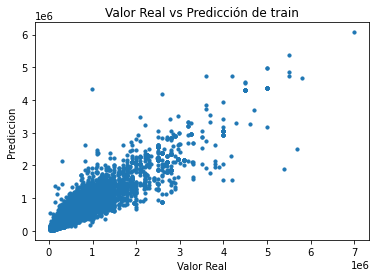

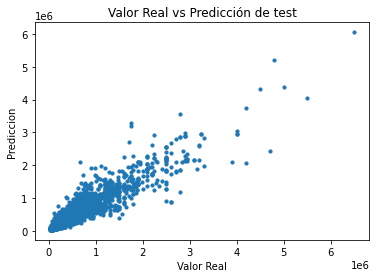

In [55]:
modelo_redes.plotear(modelo_redes.x_train, modelo_redes.y_train, 'train')
modelo_redes.plotear(modelo_redes.x_test, modelo_redes.y_test, 'test')